# CNN application on tree bark pictures

In [1]:
import os

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.constraints import unit_norm
from tensorflow.keras import regularizers
from os import listdir

Below is the list of the 7 tree types that were chosen and then the value of pictures for each label, it is quite a small dataset with the aim to expand in the future

In [2]:
pine_dir =   os.path.join('./train_new/scots_pine')
larch_dir =  os.path.join('./train_new/japanese_larch')
red_dir =    os.path.join('./train_new/coastal_redwood')
fir_dir =    os.path.join('./train_new/douglas_fir')
oak_dir =    os.path.join('./train_new/english_oak')
poplar_dir = os.path.join('./train_new/poplar')
birch_dir =  os.path.join('./train_new/silver_birch')

print('total training pine images:', len(os.listdir(pine_dir)))
print('total training larch images:', len(os.listdir(larch_dir)))
print('total training redwood images:', len(os.listdir(red_dir)))
print('total training fir images:', len(os.listdir(fir_dir)))
print('total training oak images:', len(os.listdir(oak_dir)))
print('total training poplar images:', len(os.listdir(poplar_dir)))
print('total training birch images:', len(os.listdir(birch_dir)))

total training pine images: 140
total training larch images: 184
total training redwood images: 260
total training fir images: 269
total training oak images: 194
total training poplar images: 285
total training birch images: 129


In [3]:
def rotate_images(image):
    #for some reason due to my phone camera all the images are saved in the wrong rotation
    return np.rot90(image, k=1, axes=(1,0))

BATCH_SIZE = 32

TRAINING_DIR = './train_new/'

training_datagen = ImageDataGenerator(
      rescale = 1./255,
      preprocessing_function=rotate_images,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest',
      brightness_range=[0.6,1.4],
      vertical_flip=True,
      validation_split = 0.2,
)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    color_mode = "rgb",
    target_size=(256, 256),
    class_mode='categorical',
    seed = 1,
    shuffle = True,
    batch_size=BATCH_SIZE,
    subset = 'training'
)

validation_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    color_mode = "rgb",
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 7,
    shuffle = True,
    subset = 'validation'
)

test_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    color_mode = "rgb",
    target_size=(256,256),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    seed = 7,
    shuffle = False,
    subset = 'validation'
    #test generator added with no shuffle to be used with the confusion matrix, it is otherwise the same as the valid
)

train_num = train_generator.samples
valid_num = validation_generator.samples
test_num = test_generator.samples

Found 1172 images belonging to 7 classes.
Found 289 images belonging to 7 classes.
Found 289 images belonging to 7 classes.


C:\Users\james\anaconda3\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


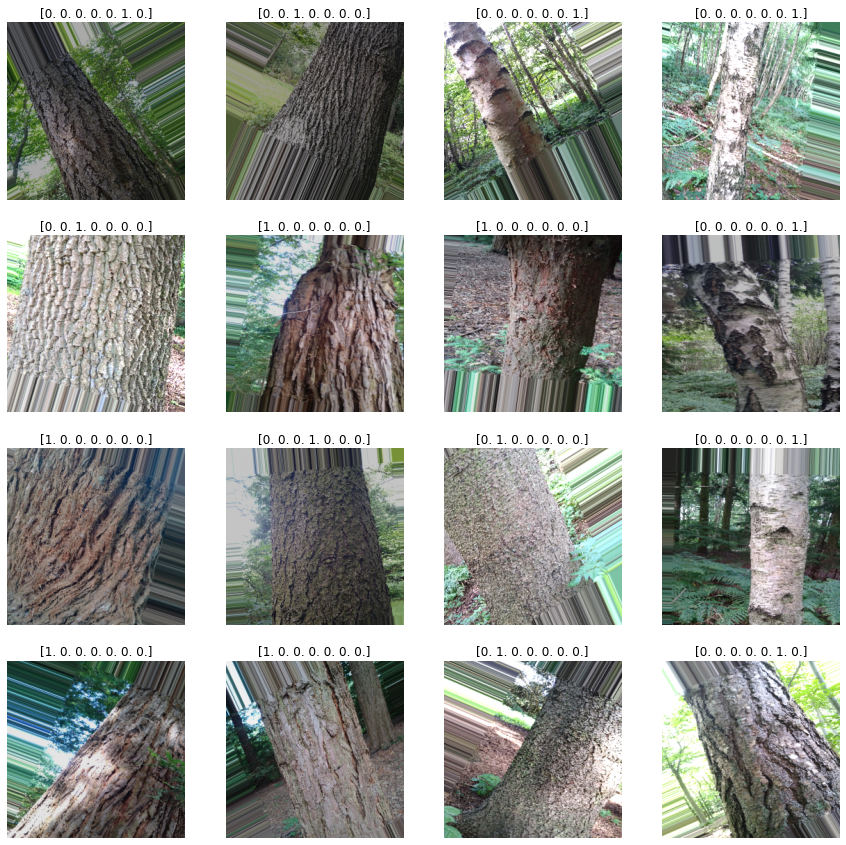

In [4]:
x = train_generator.next() #fetch the first batch
a = x[0] # train data
b = x[1] # train label
#a = rotate_and_mask(a) ##future plan not in this notebook to attempt at masking the background to focus on the main bark
rows = 4
cols = 4
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(15,15))
for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.imshow(a[i])
    ax.set_title(b[i])
    ax.axis('off')
plt.show()

Above is a selection of 16 random images from the dataset. As can be seen there is a lot of background noise which could be leading to the low accuracy values, in the future I plan to try and mask these to bring out just the bark, although this will be tricky since there is no main common background colour.

In [5]:
def NN_graph(label1, label2, values, col1, col2):
    #a quick function to create graphs that are easy to compare
    acc = values.history['accuracy']
    val_acc = values.history['val_accuracy']
    loss = values.history['loss']
    val_loss = values.history['val_loss']
    x = values.epoch

    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    ax1.plot(x, acc, col1, label ='Training ' + label1)
    ax1.plot(x, val_acc, col2, label='Validation ' + label1)
    ax1.set_title('Training and Validation ' + label1)
    ax1.legend(loc=0)
    ax2.plot(x, loss, col1, label='Training ' + label2)
    ax2.plot(x, val_loss, col2, label='Validation ' + label2)
    ax2.set_title('Training and Validation ' + label2)
    ax2.legend(loc=0)
    fig.tight_layout()

Initial model is based off the AlexNet structure but with a reduced initial filter size and two less convolutions, the original Alexnet that I tried gave very poor performance and took days to train

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 128)       512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 128)       0

Epoch 97/100
36/36 [==============================] - 370s 10s/step - loss: 0.3962 - accuracy: 0.8526 - val_loss: 1.4440 - val_accuracy: 0.5972
Epoch 98/100
36/36 [==============================] - 371s 10s/step - loss: 0.4106 - accuracy: 0.8570 - val_loss: 1.4582 - val_accuracy: 0.5972
Epoch 99/100
36/36 [==============================] - 367s 10s/step - loss: 0.3976 - accuracy: 0.8544 - val_loss: 1.8019 - val_accuracy: 0.5764
Epoch 100/100
36/36 [==============================] - 374s 10s/step - loss: 0.3813 - accuracy: 0.8667 - val_loss: 1.5669 - val_accuracy: 0.6354
INFO:tensorflow:Assets written to: rps.h1\assets


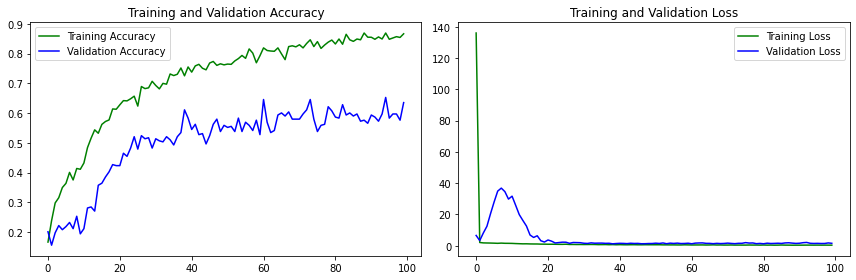

In [6]:
model = tf.keras.models.Sequential([
      
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=4, padding='valid',
                           kernel_constraint=unit_norm(), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') 
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])


history = model.fit(train_generator, epochs=100, steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data = validation_generator, verbose = 1, validation_steps = valid_num // BATCH_SIZE,
                   #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
                    )
model.save("rps.h1")

NN_graph('Accuracy', 'Loss', history, 'g', 'b')

Changing the optimiser and adding some kernel regularisation made the accuracy decrease but only slightly limited overfitting

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 63, 63, 64)        4864      
_________________________________________________________________
batch_normalization_6 (Batch (None, 63, 63, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
batch_normalization_7 (Batch (None, 31, 31, 128)       512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 31, 31, 128)      

Epoch 41/100
36/36 [==============================] - 387s 11s/step - loss: 5.9124 - accuracy: 0.6193 - val_loss: 6.1986 - val_accuracy: 0.5243
Epoch 42/100
36/36 [==============================] - 383s 11s/step - loss: 5.9037 - accuracy: 0.6132 - val_loss: 6.3095 - val_accuracy: 0.4826
Epoch 43/100
36/36 [==============================] - 386s 11s/step - loss: 5.9075 - accuracy: 0.6009 - val_loss: 6.1868 - val_accuracy: 0.5208
Epoch 44/100
36/36 [==============================] - 385s 11s/step - loss: 5.8833 - accuracy: 0.6132 - val_loss: 6.3433 - val_accuracy: 0.4965
Epoch 45/100
36/36 [==============================] - 383s 11s/step - loss: 5.8724 - accuracy: 0.6184 - val_loss: 6.2488 - val_accuracy: 0.4826
Epoch 46/100
36/36 [==============================] - 387s 11s/step - loss: 5.7805 - accuracy: 0.6325 - val_loss: 6.1974 - val_accuracy: 0.5000
Epoch 47/100
36/36 [==============================] - 386s 11s/step - loss: 5.7904 - accuracy: 0.6509 - val_loss: 6.2518 - val_accuracy:

Epoch 98/100
36/36 [==============================] - 392s 11s/step - loss: 5.2240 - accuracy: 0.7193 - val_loss: 5.9691 - val_accuracy: 0.5174
Epoch 99/100
36/36 [==============================] - 387s 11s/step - loss: 5.2194 - accuracy: 0.7114 - val_loss: 6.0174 - val_accuracy: 0.5069
Epoch 100/100
36/36 [==============================] - 391s 11s/step - loss: 5.2131 - accuracy: 0.7263 - val_loss: 5.9730 - val_accuracy: 0.4861


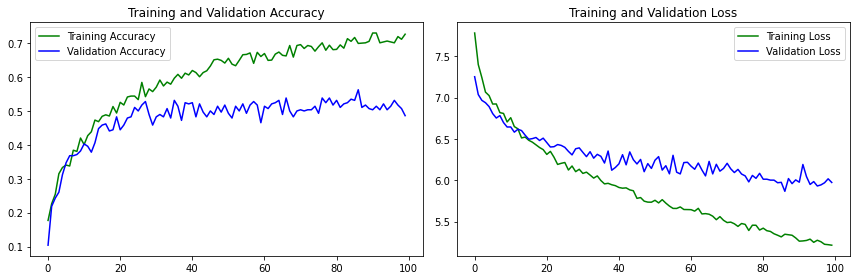

In [9]:
model = tf.keras.models.Sequential([
      
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=4, padding='valid',
                           kernel_constraint=unit_norm(), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal',
                          kernel_regularizer=regularizers.l2(l=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') 
])


model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


history = model.fit(train_generator, epochs=100, steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data = validation_generator, verbose = 1, validation_steps = valid_num // BATCH_SIZE,
                   #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=6)
                    )
model.save("rps.h2")

NN_graph('Accuracy', 'Loss', history, 'g', 'b')

Finally adding back in one of the convolutional layers further reduces overfitting and has a more optimised learning rate looking at the loss graph, but doesn't improve accuracy at all!

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 63, 63, 64)        4864      
_________________________________________________________________
batch_normalization_12 (Batc (None, 63, 63, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 31, 31, 64)        102464    
_________________________________________________________________
batch_normalization_13 (Batc (None, 31, 31, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 64)       

Epoch 38/100
36/36 [==============================] - 378s 11s/step - loss: 6.9469 - accuracy: 0.3298 - val_loss: 6.6608 - val_accuracy: 0.4132
Epoch 39/100
36/36 [==============================] - 366s 10s/step - loss: 6.8582 - accuracy: 0.3456 - val_loss: 6.6652 - val_accuracy: 0.3993
Epoch 40/100
36/36 [==============================] - 362s 10s/step - loss: 6.9071 - accuracy: 0.3386 - val_loss: 6.6700 - val_accuracy: 0.4097
Epoch 41/100
36/36 [==============================] - 374s 10s/step - loss: 6.8405 - accuracy: 0.3746 - val_loss: 6.7063 - val_accuracy: 0.3819
Epoch 42/100
36/36 [==============================] - 362s 10s/step - loss: 6.8159 - accuracy: 0.3667 - val_loss: 6.6632 - val_accuracy: 0.4306
Epoch 43/100
36/36 [==============================] - 370s 10s/step - loss: 6.8324 - accuracy: 0.3667 - val_loss: 6.6758 - val_accuracy: 0.3750
Epoch 44/100
36/36 [==============================] - 378s 11s/step - loss: 6.8191 - accuracy: 0.3640 - val_loss: 6.6891 - val_accuracy:

Epoch 95/100
36/36 [==============================] - 345s 10s/step - loss: 6.4423 - accuracy: 0.4781 - val_loss: 6.4990 - val_accuracy: 0.4479
Epoch 96/100
36/36 [==============================] - 347s 10s/step - loss: 6.4757 - accuracy: 0.4860 - val_loss: 6.4802 - val_accuracy: 0.4410
Epoch 97/100
36/36 [==============================] - 344s 10s/step - loss: 6.4914 - accuracy: 0.4711 - val_loss: 6.5549 - val_accuracy: 0.4201
Epoch 98/100
36/36 [==============================] - 350s 10s/step - loss: 6.4544 - accuracy: 0.4781 - val_loss: 6.5960 - val_accuracy: 0.4236
Epoch 99/100
36/36 [==============================] - 347s 10s/step - loss: 6.4486 - accuracy: 0.4754 - val_loss: 6.5285 - val_accuracy: 0.4132
Epoch 100/100
36/36 [==============================] - 347s 10s/step - loss: 6.4649 - accuracy: 0.4763 - val_loss: 6.4960 - val_accuracy: 0.4306


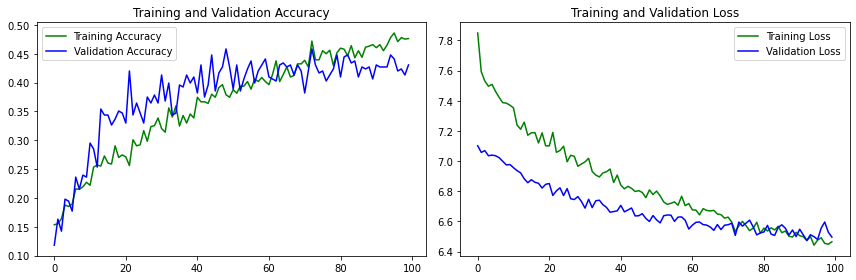

In [11]:
model = tf.keras.models.Sequential([
      
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=4, padding='valid',
                           kernel_constraint=unit_norm(), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.1),
   
    tf.keras.layers.Conv2D(64, kernel_size=(5,5), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
   
    
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256, kernel_size=(3,3), strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal',
                          kernel_regularizer=regularizers.l2(l=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid', data_format = None),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax') 
])


model.summary()

sgd = tf.keras.optimizers.SGD(learning_rate=0.00001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss = 'categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


history = model.fit(train_generator, epochs=100, steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data = validation_generator, verbose = 1, validation_steps = valid_num // BATCH_SIZE,
                   #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=6)
                    )
model.save("rps.h3")

NN_graph('Accuracy', 'Loss', history, 'g', 'b')

# Neural Network Results

Although I attempted to reduce overfitting and increase the accuracy it wasn't very succesful compared to the first NN. Due to this I just used the intial one for the final accuracy and confusion matrix

In [7]:
test_generator.samples

289

In [8]:
acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Model Accuracy on Test Data", acc[1]*100)

10/10 [==============================] - 71s 7s/step - loss: 1.4968 - accuracy: 0.6228
Model Accuracy on Test Data 62.28373646736145


In [9]:
y = test_generator.labels
#print(y)
y_pred=np.argmax(model.predict(test_generator), axis=-1)
#print(y_pred)
con_mat = tf.math.confusion_matrix(labels=y, predictions=y_pred).numpy()

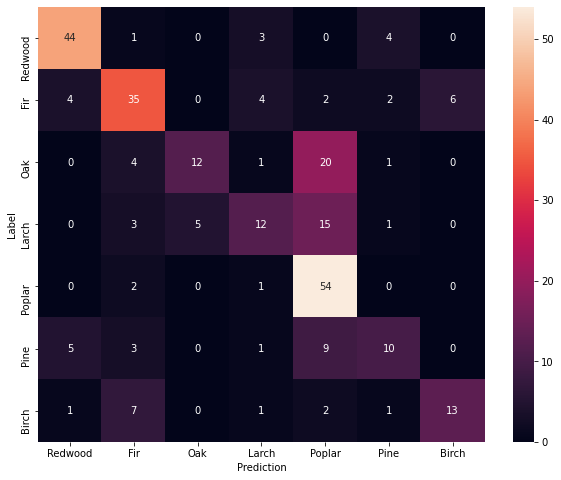

In [10]:
commands = ['Redwood', 'Fir', 'Oak', 'Larch', 'Poplar', 'Pine', 'Birch']
plt.figure(figsize=(10, 8))
scale = len(test_generator.labels) / 7 / 2
#sns.heatmap(con_mat, annot=True, fmt='g')
sns.heatmap(con_mat, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

As seen on the confusion matrix - redwood, fir, pine, and birch are all quite distinctive and easy to recognise, but the NN struggles for oak, larch, pine, and poplar. The NN almost completley accurately predicts poplars as poplars but it also consistently mislabels oaks and larches as poplars aswell. Looking at photos of these trees it can be quite easy to see why, these have quite similar bark strucutres, whereas something like the redwood is very distinctive in texture as well as colour.